In [22]:
import contextlib
import numpy as np
import pygad
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from itertools import product

In [2]:
@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)

In [3]:
vision = 3 # the number of cells to the left and right that we can see
all_possible_states = list(range(2))
cell_states_number = len(all_possible_states) # the number of possible states for a cell
cell_observe_state_number = cell_states_number**(2*vision + 1) # the number of possible states

In [4]:
def base_10_to_base_n(number, base) -> list:
    if number == 0:
        return [0]
    digits = []
    while number:
        digits.append(int(number % base))
        number //= base
    return digits[::-1]

def base_n_to_base_10(numbers, base):
    return sum([base**i * x for i, x in enumerate(numbers[::-1])])

In [5]:
with temp_seed(43):
    rule = np.random.choice(all_possible_states, cell_observe_state_number)
# rule_id = base_n_to_base_10(rule, cell_states_number)
# rule#, rule_id
len(rule)

128

In [91]:
rule = base_10_to_base_n(6667021275756174439087127638698866559, 2)
rule = [0] * (cell_observe_state_number - len(rule)) + rule
# rule = rule + [0] * (cell_observe_state_number - len(rule)) 
len(rule)

128

In [92]:

# combinations = product(all_possible_states[::-1], repeat=2*vision+1)
combinations = product(all_possible_states, repeat=2*vision+1)
rule_map = dict(zip(combinations, rule))
# rule_map

In [93]:
import numpy as np
def slicer(a, lower, upper):
    res = []
    if lower < 0:
        res = a[lower:]+a[:upper]
    elif upper > len(a):
        res= a[lower:]+a[:upper-len(a)]
    else:
        res= a[lower: upper]
    return tuple(res)

def get_state_boundless(rule, state):
    return list(rule[slicer(state,i-vision,i+vision+1)] for i in range(len(state)))

def get_random_state(length, all_possible_states=all_possible_states, seed=0):
    with temp_seed(seed):
        return tuple(np.random.choice(all_possible_states, length))


In [94]:
def visualize_states(states: np.ndarray, figsize=(10,10), cmap="viridis"):
    plt.figure(figsize=figsize)
    plt.imshow(states, cmap=cmap, interpolation="none")
    plt.axis("off")
    plt.show()


0.47


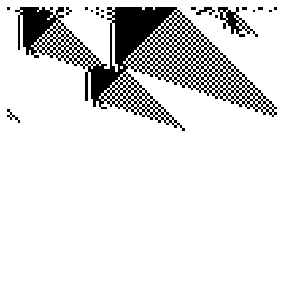

In [114]:
all_states = []
current_state = get_random_state(100, seed=None)
all_states.append(current_state)
print(sum(current_state)/len(current_state))

steps = 100
for i in range(steps):
    current_state = get_state_boundless(rule_map, current_state)
    all_states.append(current_state)

# convert the states to integers
all_states = [[int(x) for x in state] for state in all_states]
all_states = np.array(all_states)
visualize_states(all_states, figsize=(5,5), cmap="gray")

In [20]:
def predict(state, rule_map, steps=200, output_converged=False):
    for i in range(steps):
        state = get_state_boundless(rule_map, state)
    majority = np.round(sum(state)/len(state))
    if output_converged:
        return int(majority), state.count(majority)/len(state)>0.8
    else:
        return int(majority)

In [33]:
X = [get_random_state(20, all_possible_states, None) for _ in range(1000)]
y_pred = [predict(x, rule_map, 200) for x in X]
y_true = (np.array([sum(x)/len(x) for x in X])>0.5).astype(int)

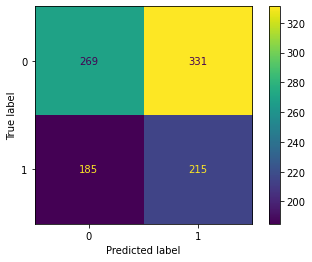

In [34]:


cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
disp.plot()

In [35]:
# print roc score, accuracy, precision, recall, f1 score

print("roc score:", roc_auc_score(y_true, y_pred))
print("accuracy:", accuracy_score(y_true, y_pred))
print("precision:", precision_score(y_true, y_pred))
print("recall:", recall_score(y_true, y_pred))
print("f1 score:", f1_score(y_true, y_pred))

roc score: 0.49291666666666667
accuracy: 0.484
precision: 0.39377289377289376
recall: 0.5375
f1 score: 0.45454545454545453


|size|roc score|
|----|---------|
|20|0.84|
|100|0.8|
|200|0.75|

### input
1. an array of binary values

### parameters
1. a rule for determining the next value of an element based on the element and its neighbors

### procedure
1. for each element in the array, apply the rule to the element and its neighbors
2. repeat step 1 for a given number of iterations

### output
1. the majority of the input array

In [79]:
PREDICT_STEPS = 100
FITNESS_NUMBER = 50
PREDICT_CELL_NUMBER = 20


In [80]:
large_X = [get_random_state(PREDICT_CELL_NUMBER, all_possible_states, None) for _ in range(10000)]
large_y = (np.array([sum(x)/len(x) for x in large_X])>0.5).astype(int)
def generate_x_y(x_num):
    X = []
    y = []
    for i in range(x_num):
        idx = np.random.choice(np.where(large_y==i%2)[0])
        X.append(large_X[idx])
        y.append(large_y[idx])
    return X, y

In [81]:
def fitness_func(ga_instance, solution, solution_idx):
    combinations = product(all_possible_states, repeat=2*vision+1)
    rule_map = dict(zip(combinations, solution))
    X, y_true = generate_x_y(FITNESS_NUMBER)
    y_pred = []
    converged_li = []

    for x in X:
        y, converged = predict(x, rule_map, PREDICT_STEPS, output_converged=True)
        y_pred.append(y)
        converged_li.append(converged)

    try :
        roc = roc_auc_score(y_true, y_pred)
        converge_rate = sum(converged_li)/len(converged_li)
        fitness = converge_rate/(1-roc-0.0001)
    except:
        print("error")
        print(y_pred, y_true, solution, X)
        raise
    return fitness

def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])


In [82]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
sol_per_pop = 30
initial_population = np.random.randint(low=0, high=2, size=(sol_per_pop, len(rule_map)))
initial_population[0] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
initial_population[1] = [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
initial_population = initial_population.tolist()

ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=4,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=len(rule_map),
    # init_range_low=0,
    # init_range_high=2,
    initial_population=initial_population,
    gene_space=(0,1),
    parent_selection_type="sss",
    keep_parents=1,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10,
    save_solutions=False,
    gene_type=int,
    logger=logger,
    on_generation=on_gen,
)


In [83]:
ga_instance.run()

Generation :  1
Fitness of the best solution : 3.6167756829549824
Generation :  2
Fitness of the best solution : 3.6167756829549824
Generation :  3
Fitness of the best solution : 4.4022011005502755
Generation :  4
Fitness of the best solution : 4.274670304683947
Generation :  5
Fitness of the best solution : 4.274670304683947
Generation :  6
Fitness of the best solution : 4.274670304683947
Generation :  7
Fitness of the best solution : 4.274670304683947
Generation :  8
Fitness of the best solution : 4.274670304683947
Generation :  9
Fitness of the best solution : 4.502251125562783
Generation :  10
Fitness of the best solution : 5.336297943301832
Generation :  11
Fitness of the best solution : 4.502251125562783
Generation :  12
Fitness of the best solution : 4.502251125562783
Generation :  13
Fitness of the best solution : 4.502251125562783
Generation :  14
Fitness of the best solution : 4.502251125562783
Generation :  15
Fitness of the best solution : 4.502251125562783
Generation :  16

In [88]:
1-2/4.860614724803431

0.5885294117647059

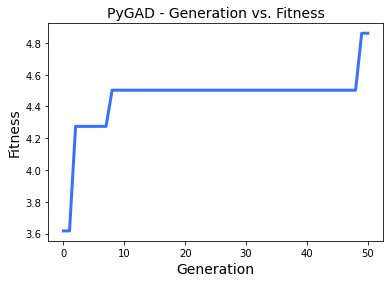

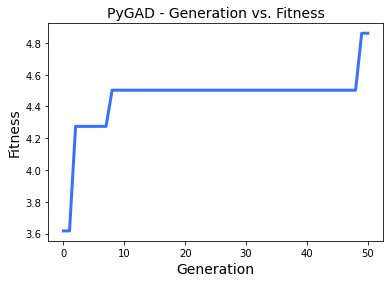

In [84]:
ga_instance.plot_fitness()

In [76]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=list(solution)))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))


Parameters of the best solution : [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Fitness value of the best solution = 12.495594501938411


In [67]:
base_n_to_base_10([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
                  1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 2)


112373531042651088062359351169203679

|  id   | roc |  solution   |
| --- | --- | --- |
|   1  |   0.75  | [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]  |
|   2  |     |     |
|   3  |     |     |
|   4  |     |     |
|   5  |     |     |



In [85]:
X2, y_true2 = generate_x_y(2000)

combinations = product(all_possible_states, repeat=2*vision+1)
rule_map = dict(zip(combinations, solution))
y_pred2 = [predict(x, rule_map, PREDICT_STEPS) for x in X2]
print("roc score:", roc_auc_score(y_true2, y_pred2))


roc score: 0.6944999999999999


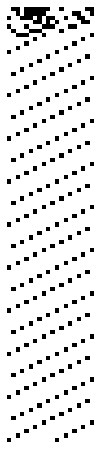

predicted: 1 true: 0 converged: True


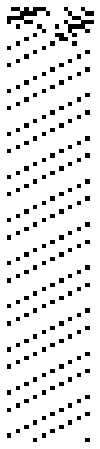

predicted: 1 true: 1 converged: True


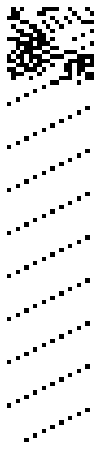

predicted: 1 true: 1 converged: True


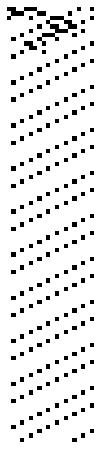

predicted: 1 true: 1 converged: True


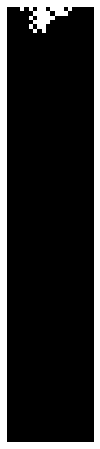

predicted: 0 true: 0 converged: True


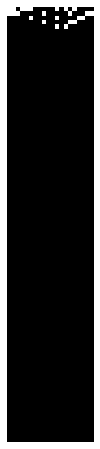

predicted: 0 true: 0 converged: True


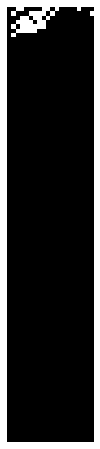

predicted: 0 true: 0 converged: True


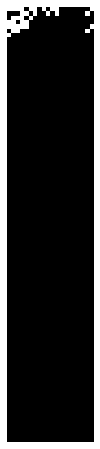

predicted: 0 true: 0 converged: True


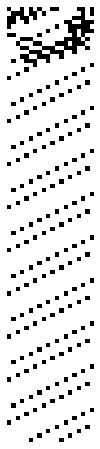

predicted: 1 true: 1 converged: True


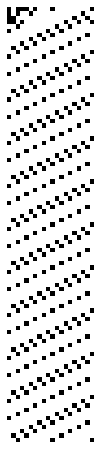

predicted: 1 true: 1 converged: True


In [90]:
for idx in np.random.choice(range(len(X2)), 10):
    init_state = X2[idx]
    y = y_true2[idx]
    all_states = [init_state]
    current_state = init_state
    for i in range(PREDICT_STEPS):
        current_state = get_state_boundless(rule_map, current_state)
        all_states.append(current_state)
    all_states = [[int(x) for x in state] for state in all_states]
    all_states = np.array(all_states)
    visualize_states(all_states, figsize=(5,8), cmap="gray")
    combinations = product(all_possible_states, repeat=2*vision+1)
    rule_map = dict(zip(combinations, solution))
    prediction, converged = predict(init_state, rule_map, PREDICT_STEPS, output_converged=True)
    print("predicted:", prediction, "true:", y, "converged:", converged)